### A notebook for visually and quantitative evaluating the poses predicted by models. 
We render the mesh, show the 2g keypoints, the keypoints from the predicted mesh and the keypoints from the gt mesh. We also calculate the reprojection loss and the reconstruction loss.

In [1]:
import sys
import os
sys.path.append("../")

In [2]:
os.environ['PYOPENGL_PLATFORM'] = 'egl'
os.environ['EGL_DEVICE_ID']=str(2)

In [3]:
import config

import numpy as np
import matplotlib.pyplot as plt
import json
import cv2
import os
import torch
import torch.nn.functional as F
from smplx.lbs import vertices2joints

from data.eft_dataset import EFTDataset
from data.eval_dataset import Dataset_3DPW
from data.display_utils import display_model
from models.smpl import get_smpl_model
from data.utils import rot6d_to_rotmat,orth_proj,reconstruction_error,reconstruction_error_per_part
import constants
import config

In [4]:
from models.hmr import HMR
from models.hmr2 import HMR2
from models.hmr4 import HMR4
#from models.prohmr import ProHMR
cfg = {'model':{'custom_backbone':True,
       'norelu':True,
       'use_extra_smpl':True}
}

model_hmr = HMR(cfg=cfg)
model_hmr2 = HMR2(cfg=cfg)
model_hmr4 = HMR4(cfg=cfg)
#model_prohmr = ProHMR(cfg=cfg)

MODEL REGRESSOR ARCHITECTURE
Sequential(
  (0): Linear(in_features=2205, out_features=1024, bias=True)
  (1): Identity()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1024, out_features=1024, bias=True)
  (4): Identity()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=1024, out_features=157, bias=True)
)
LOG:: Using custom BackBone
MODEL REGRESSOR ARCHITECTURE
Sequential(
  (0): Linear(in_features=2205, out_features=1024, bias=True)
  (1): Identity()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1024, out_features=1024, bias=True)
  (4): Identity()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=1024, out_features=147, bias=True)
)
Sequential(
  (0): Linear(in_features=2058, out_features=512, bias=True)
  (1): Identity()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): Identity()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=512, out_features=10, bias=

In [5]:
chkpt_hmr = torch.load('/gpu-data/skar/experiments/hmr_custom_backbone_norelu_withshapeloss_withreprojectionloss_l1loss_cont2/best.pt',map_location='cpu')
chkpt_hmr2 = torch.load('/gpu-data/skar/experiments/hmr2_custom_backbone_norelu_predshap_noshapeloss_withreprojectionloss_l1loss/best.pt',map_location='cpu')
chkpt_hmr4 = torch.load('/gpu-data/skar/experiments/hmr4_custom_backbone_norelu_predjointsfeats_withreprojectionloss_l1loss/best.pt',map_location='cpu')
#chkpt_prohmr = torch.load('/gpu-data2/skar/experiments/prohmr_custom_backbone_withshapeloss_withreprojectionloss_extrasmpl_withexplosses_cont/best.pt',map_location='cpu')
#print(chkpt.keys())

model_hmr.load_state_dict(chkpt_hmr['model_state_dict'])
model_hmr2.load_state_dict(chkpt_hmr2['model_state_dict'])
model_hmr4.load_state_dict(chkpt_hmr4['model_state_dict'])
#model_prohmr.load_state_dict(chkpt_prohmr['model_state_dict'])
model_hmr = model_hmr.eval()
model_hmr2 = model_hmr2.eval()
model_hmr4 = model_hmr4.eval()
#model_prohmr = model_prohmr.eval()

In [6]:
dataset = EFTDataset(datasets=['coco14_val'],is_train=False)

In [53]:
dataset = Dataset_3DPW()

In [111]:
smpl = get_smpl_model(use_feet_keypoints=True,use_hands=True,extra=True)

In [58]:
sample = dataset[10]#11 is the man with the disc

In [21]:
rdir =torch.randn(1,144)
rdir = rdir/torch.linalg.norm(rdir)

In [35]:
orch.save(rdir,'rdir.pt')

In [98]:
cam,pose,shape = model_hmr(sample['img'].unsqueeze(0))
print(1)
pose_mat = rot6d_to_rotmat(pose[-1].reshape(-1,6)).reshape(-1,24,3,3).flatten(2,3)
print(2)
output_hmr = smpl(global_orient=pose_mat[:,:1,:],body_pose=pose_mat[:,1:,:],betas=shape[-1],pose2rot=False)
print(3)

1
2
3


In [109]:
#cam,pose,shape = model_hmr(sample['img'].unsqueeze(0))
#pose_mat = rot6d_to_rotmat(pose[-1].reshape(-1,6)).reshape(-1,24,3,3).flatten(2,3)
#output_hmr = smpl(global_orient=pose_mat[:,:1,:],body_pose=pose_mat[:,1:,:],betas=shape[-1],pose2rot=False)
#pose,shape,_ = model_prohmr.sample(sample['img'].unsqueeze(0))
#pose_mat = rot6d_to_rotmat(pose.reshape(-1,6)).reshape(-1,24,3,3).flatten(2,3)
#output_prohmr1 = smpl(global_orient=pose_mat[:,:1,:],body_pose=pose_mat[:,1:,:],betas=shape,pose2rot=False)
#

#z = 21*rdir
#pose,shape,_ = model_prohmr.inference(sample['img'].unsqueeze(0),z=z)
#pose_mat = rot6d_to_rotmat(pose.reshape(-1,6)).reshape(-1,24,3,3).flatten(2,3)
#output_prohmr2 = smpl(global_orient=pose_mat[:,:1,:],body_pose=pose_mat[:,1:,:],betas=shape,pose2rot=False)

pose_gt = sample['pose'].unsqueeze(0)
shape_gt = sample['shape'].unsqueeze(0)
#cam_gt = sample['cam'].unsqueeze(0)
output_gt = smpl(global_orient=pose_gt[:,:3],body_pose=pose_gt[:,3:],betas=shape_gt,pose2rot=True)

In [107]:
sample = dataset[430]

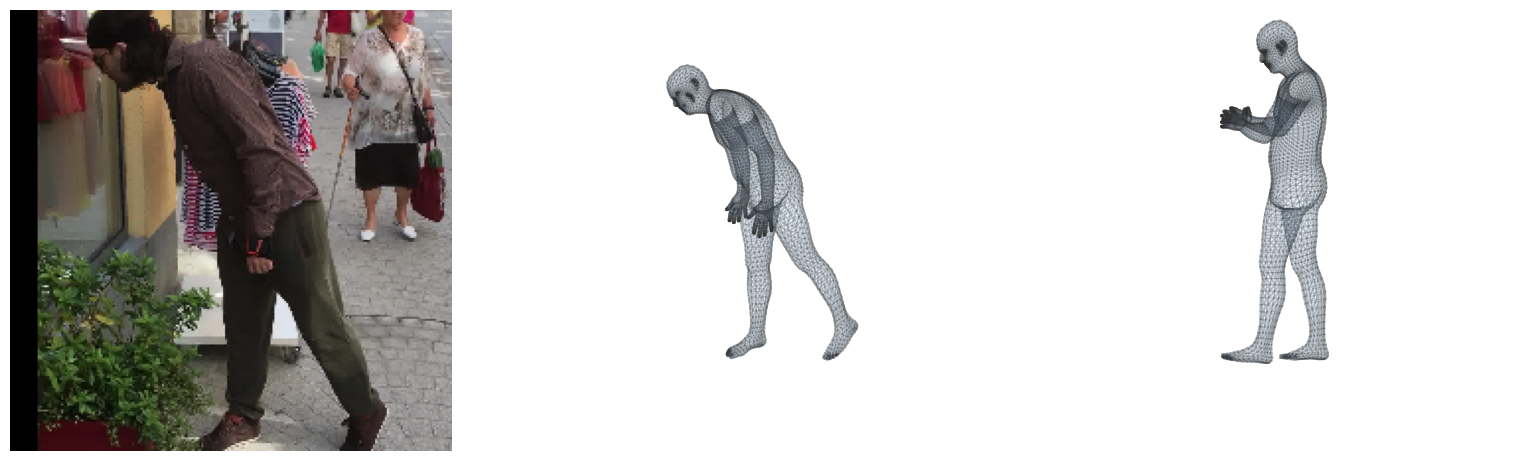

In [110]:
fig= plt.figure(figsize=(15,5))
ax1 = fig.add_axes(131)
ax2 = fig.add_axes(132,projection='3d')
ax3 = fig.add_axes(133,projection='3d')

mean=torch.tensor([0.485, 0.456, 0.406])
std=torch.tensor([0.229, 0.224, 0.225])
img = sample['img']*std.unsqueeze(-1).unsqueeze(-1) + mean.unsqueeze(-1).unsqueeze(-1)
ax1.imshow(img.permute(1,2,0).numpy())
ax1.set_axis_off()

ax3 = display_model(
            {'verts': output_hmr.vertices.cpu().detach(),
             'joints': output_hmr.joints[0,:24,:].cpu().detach()},
            model_faces=smpl.faces.astype(int),
            with_joints=False,
            kintree_table=smpl.parents,
            savepath=None,
            show=False,
            ax=ax3,
            alpha=0.1)
ax3.view_init(elev=-90,azim=-90)
ax3.set_axis_off()

ax2 = display_model(
            {'verts': output_gt.vertices.cpu().detach(),
             'joints': output_gt.joints[0,:24,:].cpu().detach()},
            model_faces=smpl.faces.astype(int),
            with_joints=False,
            kintree_table=smpl.parents,
            savepath=None,
            show=False,
            ax=ax2)
ax2.view_init(elev=-90,azim=-90)
ax2.set_axis_off()

Interlude for ProHMR

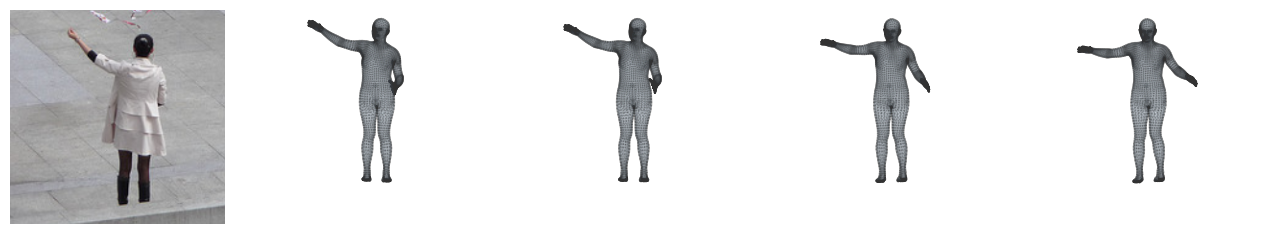

In [57]:
fig= plt.figure(figsize=(15,5))
ax1 = fig.add_axes(161)
ax2 = fig.add_axes(162,projection='3d')
ax3 = fig.add_axes(163,projection='3d')
ax4 = fig.add_axes(164,projection='3d')
ax5 = fig.add_axes(165,projection='3d')

axs = [ax2,ax3,ax4,ax5]

mean=torch.tensor([0.485, 0.456, 0.406])
std=torch.tensor([0.229, 0.224, 0.225])
img = sample['img']*std.unsqueeze(-1).unsqueeze(-1) + mean.unsqueeze(-1).unsqueeze(-1)
ax1.imshow(img.permute(1,2,0).numpy())
ax1.set_axis_off()

coeffs = [16,17,18,19]
for i in range(4):
    z = coeffs[i]*rdir
    pose,shape,_ = model_prohmr.inference(sample['img'].unsqueeze(0),z=z)
    pose_mat = rot6d_to_rotmat(pose.reshape(-1,6)).reshape(-1,24,3,3).flatten(2,3)
    output_prohmr2 = smpl(global_orient=pose_mat[:,:1,:],body_pose=pose_mat[:,1:,:],betas=shape,pose2rot=False)

    axs[i] = display_model(
                {'verts': output_prohmr2.vertices.cpu().detach(),
                 'joints': output_prohmr2.joints[0,:24,:].cpu().detach()},
                model_faces=smpl.faces.astype(int),
                with_joints=False,
                kintree_table=smpl.parents,
                savepath=None,
                show=False,
                ax=axs[i],
                alpha=0.1)
    axs[i].view_init(elev=-90,azim=-90)
    axs[i].set_axis_off()

In [51]:
sample = dataset[170]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT 2d keypoints
Hidden gt joints(ids): [37, 38, 39, 40]
Hidden gt joints(names): ['Neck (LSP)', 'Top of Head (LSP)', 'Pelvis (MPII)', 'Thorax (MPII)']
Projecting the predicted mesh


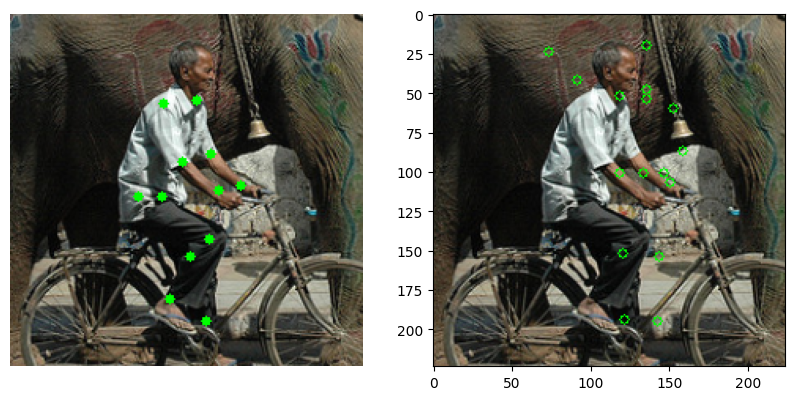

In [52]:
fig= plt.figure(figsize=(10,5))
ax1 = fig.add_axes(121)
ax2 = fig.add_axes(122)
#ax3 = fig.add_axes(133)

print("GT 2d keypoints")
kp2s = sample['keypoints2d'].to(int).numpy()
mean=torch.tensor([0.485, 0.456, 0.406])
std=torch.tensor([0.229, 0.224, 0.225])
img = sample['img']*std.unsqueeze(-1).unsqueeze(-1) + mean.unsqueeze(-1).unsqueeze(-1)
new_img = img.permute(1,2,0).numpy()

hidden = []

for i in range(25,41):
    if sample['visibility2d'][i] > 0:
        color = (0,225,0)
        new_img = cv2.circle(new_img,center=(kp2s[i][0],kp2s[i][1]),radius=3,color=color,thickness=-1)
    else:
        hidden.append(i)

print("Hidden gt joints(ids):",hidden)
print("Hidden gt joints(names):",[constants.JOINT_NAMES[h] for h in hidden])

ax1.imshow(new_img)
ax1.set_axis_off()

print("Projecting the predicted mesh")
pred_kp = orth_proj(output_hmr.joints,cam[-1]).squeeze(0)
pred_kp = (pred_kp.detach().numpy() + 1)*112
pred_kp = pred_kp.astype(int)

img = sample['img']*std.unsqueeze(-1).unsqueeze(-1) + mean.unsqueeze(-1).unsqueeze(-1)
new_img = img.permute(1,2,0).numpy()

for i in range(25,41):
    new_img = cv2.circle(new_img,center=(pred_kp[i][0],pred_kp[i][1]),radius=3,color=(0,255,0))

ax2.imshow(new_img)
    
#print("Projecting the gt mesh")
#pred_kp_gt = orth_proj(output_gt.joints,cam_gt[-1]).squeeze(0)
#pred_kp_gt = (pred_kp_gt.detach().numpy() + 1)*112
#pred_kp_gt = pred_kp_gt.astype(int)
#
#img = sample['img']*std.unsqueeze(-1).unsqueeze(-1) + mean.unsqueeze(-1).unsqueeze(-1)
#new_img = img.permute(1,2,0).numpy()
#
#for i in range(25,41):
#    new_img = cv2.circle(new_img,center=(pred_kp_gt[i][0],pred_kp_gt[i][1]),radius=3,color=(0,255,0))
#
#ax3.imshow(new_img)

In [178]:
print("Calculating the reprojection losses")

#to torch
pred_kp = torch.tensor(pred_kp,dtype=torch.float32)
gt_kp = torch.tensor(kp2s,dtype=torch.float32)
pred_kp_gt = torch.tensor(pred_kp_gt,dtype=torch.float32)

#normalizing
pred_kp = pred_kp/128 - 1
pred_kp_gt = pred_kp_gt/128 - 1
gt_kp = gt_kp/128 - 1

reproj_loss = (F.mse_loss(pred_kp,gt_kp,reduction='none')*sample['visibility2d'].unsqueeze(1)).sum()
print("Reprojection loss for predicted mesh:",reproj_loss.item())

reproj_loss = (F.mse_loss(pred_kp_gt,gt_kp,reduction='none')*sample['visibility2d'].unsqueeze(1)).sum()
print("Reprojection loss for predicted mesh:",reproj_loss.item())

Calculating the reprojection losses
Reprojection loss for predicted mesh: 0.130126953125
Reprojection loss for predicted mesh: 0.00604248046875


In [179]:
print("Calculating the reconstruction loss")


j36m_regressor= torch.from_numpy(np.load(config.JOINT_REGRESSOR_H36M)).to(dtype=torch.float32)

pred_vertices = output_hmr.vertices
gt_vertices = output_gt.vertices

pred_h36joints = vertices2joints(j36m_regressor,pred_vertices)
gt_h36joints = vertices2joints(j36m_regressor,gt_vertices)

predj14 = pred_h36joints[:,constants.H36M_TO_J14]
gtj14 = gt_h36joints[:,constants.H36M_TO_J14]

error = reconstruction_error(predj14.detach().numpy(),gtj14.detach().numpy(),reduction='sum')
print('Reconstruction_error:',error)

Calculating the reconstruction loss
Reconstruction_error: 0.03747946


In [180]:
print("Calculating the per part reconstruction loss")

h36joint_names = ['right_ankle','right_knee','right_hip','left_hip','left_knee','left_ankle','right_hand','right_elbow','right_shoulder','left_shoulder','left_elbow','left_hand',
                  'neck','top_of_head']

error = reconstruction_error_per_part(predj14.detach().numpy(),gtj14.detach().numpy()).squeeze(0)

print('Reconstruction_error per part(mm):')
for i in range(len(h36joint_names)):
    print(h36joint_names[i],":",error[i])

Calculating the per part reconstruction loss
Reconstruction_error per part(mm):
right_ankle : 0.044437032
right_knee : 0.031119017
right_hip : 0.04975581
left_hip : 0.0130044175
left_knee : 0.025693456
left_ankle : 0.043984797
right_hand : 0.119360484
right_elbow : 0.044517826
right_shoulder : 0.025251357
left_shoulder : 0.007169046
left_elbow : 0.030584563
left_hand : 0.042717688
neck : 0.019103173
top_of_head : 0.028013766


#### Rendering

In [113]:
from data.vibe_renderer import Renderer

In [114]:
renderer = Renderer(resolution=(224, 224), orig_img=True)

In [68]:
len(dataset)

35515

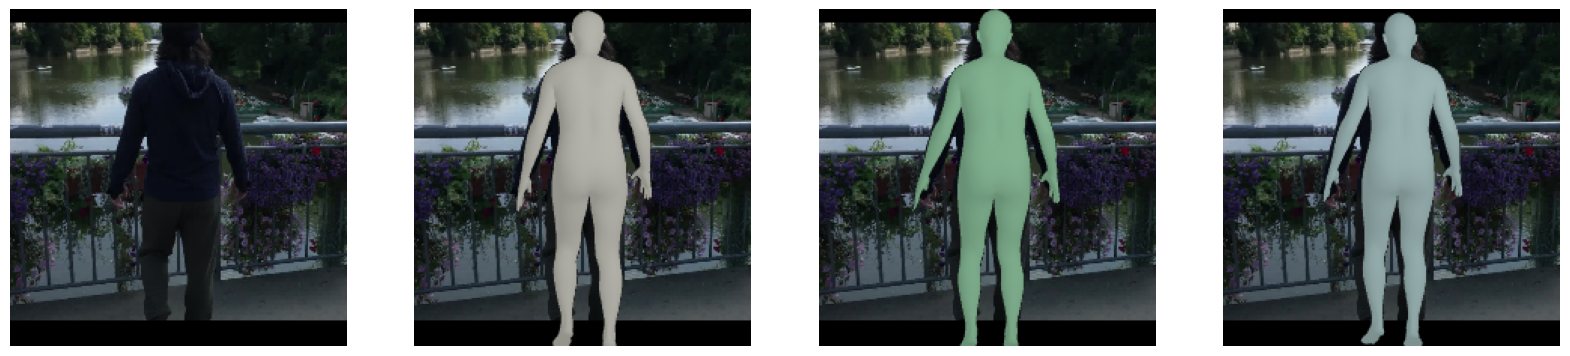

In [178]:
sample = dataset[3410]#11 is the man with the disc

fig,axs = plt.subplots(1,4,figsize=(20,5))

cam_hmr,pose_hmr,shape_hmr = model_hmr(sample['img'].unsqueeze(0))
pose_mat_hmr = rot6d_to_rotmat(pose_hmr[-1].reshape(-1,6)).reshape(-1,24,3,3).flatten(2,3)
output_hmr = smpl(global_orient=pose_mat_hmr[:,:1,:],body_pose=pose_mat_hmr[:,1:,:],betas=shape_hmr[-1],pose2rot=False)

cam_hmr2,pose_hmr2,shape_hmr2 = model_hmr2(sample['img'].unsqueeze(0))
pose_mat_hmr2 = rot6d_to_rotmat(pose_hmr2[-1].reshape(-1,6)).reshape(-1,24,3,3).flatten(2,3)
output_hmr2 = smpl(global_orient=pose_mat_hmr2[:,:1,:],body_pose=pose_mat_hmr2[:,1:,:],betas=shape_hmr2[-1],pose2rot=False)

cam_hmr4,pose_hmr4,shape_hmr4,_ = model_hmr4(sample['img'].unsqueeze(0))
pose_mat_hmr4 = rot6d_to_rotmat(pose_hmr4[-1].reshape(-1,6)).reshape(-1,24,3,3).flatten(2,3)
output_hmr4 = smpl(global_orient=pose_mat_hmr4[:,:1,:],body_pose=pose_mat_hmr4[:,1:,:],betas=shape_hmr4[-1],pose2rot=False)

aug_cam_hmr = torch.tensor([cam_hmr[-1][0][0],cam_hmr[-1][0][0],cam_hmr[-1][0][1],cam_hmr[-1][0][2]])
aug_cam_hmr2 = torch.tensor([cam_hmr2[-1][0][0],cam_hmr2[-1][0][0],cam_hmr2[-1][0][1],cam_hmr2[-1][0][2]])
aug_cam_hmr4 = torch.tensor([cam_hmr4[-1][0][0],cam_hmr4[-1][0][0],cam_hmr4[-1][0][1],cam_hmr4[-1][0][2]])


mean=torch.tensor([0.485, 0.456, 0.406])
std=torch.tensor([0.229, 0.224, 0.225])
img = sample['img']*std.unsqueeze(-1).unsqueeze(-1) + mean.unsqueeze(-1).unsqueeze(-1)
axs[0].imshow(img.permute(1,2,0).numpy())

myimg = img.permute(1,2,0).numpy().copy()
myimg=(myimg*255).astype(np.uint8)
res_hmr = renderer.render(myimg,output_hmr.vertices[0].detach().numpy(),aug_cam_hmr.numpy())
res_hmr2 = renderer.render(myimg,output_hmr2.vertices[0].detach().numpy(),aug_cam_hmr2.numpy(),color=[0.47,0.96,0.60])
res_hmr4 = renderer.render(myimg,output_hmr4.vertices[0].detach().numpy(),aug_cam_hmr4.numpy(),color=[0.69,0.96,0.96])

axs[1].imshow(res_hmr)
axs[2].imshow(res_hmr2)
axs[3].imshow(res_hmr4)

for ax in axs:
    ax.set_axis_off()


In [125]:
aug_cam_hmr

tensor([1.1038, 1.1038, 0.0056, 0.0764])

In [122]:
img.permute(1,2,0).numpy().shape

(224, 224, 3)

In [42]:
myimg = img.permute(1,2,0).numpy().copy()

In [46]:
myimg.shape

(224, 224, 3)

In [65]:
res = renderer.render(myimg,output_hmr.vertices[0].detach().numpy(),aug_cam.numpy())

In [61]:
myimg=(myimg*255).astype(np.uint8)

In [64]:
myimg.min()

0

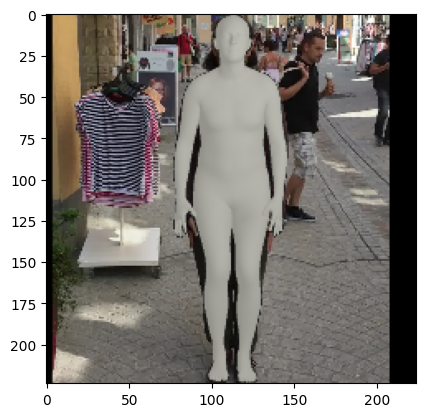

In [66]:
plt.imshow(res)